In [ ]:
import json
from pathlib import Path
import torch
from torch.utils.data import DataLoader
import time

In [ ]:
%%capture
!mkdir squad
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O squad/train-v2.0.json
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json -O squad/dev-v2.0.json

In [ ]:
%%capture
!pip install transformers

In [ ]:
import json
import random
from pathlib import Path

# Give the path for train data
path = Path('/content/squad/train-v2.0.json')

# Open .json file
with open(path, 'rb') as f:
    squad_dict = json.load(f)

texts = []
queries = []
answers = []

# Search for each passage, its question and its answer
for group in squad_dict['data']:
    for passage in group['paragraphs']:
        context = passage['context']
        for qa in passage['qas']:
            question = qa['question']
            for answer in qa['answers']:
                texts.append(context)
                queries.append(question)
                answers.append(answer)

# Calculate the number of samples to take
num_samples = int(len(texts) * 1)  # Take 100% of the data

# Randomly select the samples
random_indices = random.sample(range(len(texts)), num_samples)
train_texts = [texts[i] for i in random_indices]
train_queries = [queries[i] for i in random_indices]
train_answers = [answers[i] for i in random_indices]

In [ ]:
# Give the path for validation data
path = Path('/content/squad/dev-v2.0.json')

# Open .json file
with open(path, 'rb') as f:
    squad_dict = json.load(f)

texts = []
queries = []
answers = []

for group in squad_dict['data']:
    for passage in group['paragraphs']:
        context = passage['context']
        for qa in passage['qas']:
            question = qa['question']
            for answer in qa['answers']:
                texts.append(context)
                queries.append(question)
                answers.append(answer)

val_texts, val_queries, val_answers = texts, queries, answers



In [ ]:
print(len(train_texts))
print(len(train_queries))
print(len(train_answers))

86821
86821
86821


In [ ]:
print("Passage: ",train_texts[0])
print("Query: ",train_queries[0])
print("Answer: ",train_answers[0])

Passage:  Attempts are frequently made to regulate emotion according to the conventions of the society and the situation based on many (sometimes conflicting) demands and expectations which originate from various entities. The emotion of anger is in many cultures discouraged in girls and women, while fear is discouraged in boys and men. Expectations attached to social roles, such as "acting as man" and not as a woman, and the accompanying "feeling rules" contribute to the differences in expression of certain emotions. Some cultures encourage or discourage happiness, sadness, or jealousy, and the free expression of the emotion of disgust is considered socially unacceptable in most cultures. Some social institutions are seen as based on certain emotion, such as love in the case of contemporary institution of marriage. In advertising, such as health campaigns and political messages, emotional appeals are commonly found. Recent examples include no-smoking health campaigns and political cam

In [ ]:
print(len(val_texts))
print(len(val_queries))
print(len(val_answers))

20302
20302
20302


In [ ]:
print("Passage: ",val_texts[0])
print("Query: ",val_queries[0])
print("Answer: ",val_answers[0])

Passage:  The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.
Query:  In what country is Normandy located?
Answer:  {'text': 'France', 'answer_start': 159}


In [ ]:
for answer, text in zip(train_answers, train_texts):
    real_answer = answer['text']
    start_idx = answer['answer_start']
    # Get the real end index
    end_idx = start_idx + len(real_answer)

    # Deal with the problem of 1 or 2 more characters
    if text[start_idx:end_idx] == real_answer:
        answer['answer_end'] = end_idx
    # When the real answer is more by one character
    elif text[start_idx-1:end_idx-1] == real_answer:
        answer['answer_start'] = start_idx - 1
        answer['answer_end'] = end_idx - 1
    # When the real answer is more by two characters
    elif text[start_idx-2:end_idx-2] == real_answer:
        answer['answer_start'] = start_idx - 2
        answer['answer_end'] = end_idx - 2

In [ ]:
!pip install transformers
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.5 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer, AdamW, BertForQuestionAnswering

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")  # Use ALBERT tokenizer

train_encodings = tokenizer(train_texts, train_queries, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, val_queries, truncation=True, padding=True)

model = BertForQuestionAnswering.from_pretrained("bert-base-uncased")  # Use ALBERT model for question answering

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def add_token_positions(encodings, answers, tokenizer):
    start_positions = []
    end_positions = []

    count = 0

    for i in range(len(answers)):
        start_pos = encodings.char_to_token(i, answers[i].get('answer_start', 0))
        end_pos = encodings.char_to_token(i, answers[i].get('answer_end', 0))

        # if start position is None, the answer passage has been truncated
        start_positions.append(start_pos if start_pos is not None else tokenizer.model_max_length)

        # if end position is None, adjust it
        if end_pos is None:
            # Use tokenizer.model_max_length if 'answer_end' is missing or None
            end_positions.append(tokenizer.model_max_length)
            count += 1
        else:
            end_positions.append(end_pos)

    print(count)

    # Update the data in the dictionary
    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

# Assuming tokenizer is your Hugging Face tokenizer
add_token_positions(train_encodings, train_answers, tokenizer)
add_token_positions(val_encodings, val_answers, tokenizer)


46269
0


In [ ]:
!pip install torch
import torch

In [ ]:
class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [ ]:
train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available()
                      else 'cpu')

In [ ]:
from transformers import BertForQuestionAnswering, BertTokenizer, AdamW
import torch

# Define your device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the ALBERT model and tokenizer
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased').to(device)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define your optimizer
optim = AdamW(model.parameters(), lr=2e-5)

epochs = 2

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
import time
import torch
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from transformers import AutoTokenizer, BertForQuestionAnswering
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Assuming you have 'train_loader' and 'val_loader' ready

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model and optimizer
model = BertForQuestionAnswering.from_pretrained("bert-base-uncased").to(device)
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

epochs = 3
print_every = 500
accumulate_steps = 4  # Accumulate gradients over multiple steps

scaler = GradScaler()

train_losses = []
val_losses = []

whole_train_eval_time = time.time()

for epoch in range(epochs):
    epoch_time = time.time()

    model.train()
    loss_of_epoch = 0

    print("############ Train ############")

    train_loader_iterator = tqdm(enumerate(train_loader), total=len(train_loader))

    for batch_idx, batch in train_loader_iterator:

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)

        optimizer.zero_grad()

        with autocast():
            outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
            loss = outputs.loss
        scaler.scale(loss).backward()

        if (batch_idx + 1) % accumulate_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        loss_of_epoch += loss.item()

        if (batch_idx + 1) % print_every == 0:
            train_loader_iterator.set_postfix({"Loss": round(loss.item(), 1)})

    loss_of_epoch /= len(train_loader)
    train_losses.append(loss_of_epoch)

    model.eval()
    loss_of_epoch = 0

    print("############ Evaluate ############")

    val_loader_iterator = tqdm(enumerate(val_loader), total=len(val_loader))

    with torch.no_grad():
        for batch_idx, batch in val_loader_iterator:

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            with autocast():
                outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
                loss = outputs.loss

            loss_of_epoch += loss.item()

            if (batch_idx + 1) % print_every == 0:
                val_loader_iterator.set_postfix({"Loss": round(loss.item(), 1)})

    loss_of_epoch /= len(val_loader)
    val_losses.append(loss_of_epoch)

    print("\n------- Epoch ", epoch + 1,
          " -------"
          "\nTraining Loss:", train_losses[-1],
          "\nValidation Loss:", val_losses[-1],
          "\nTime: ", (time.time() - epoch_time),
          "\n-----------------------",
          "\n\n")

print("Total training and evaluation time: ", (time.time() - whole_train_eval_time))


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


############ Train ############


100%|██████████| 5427/5427 [48:55<00:00,  1.85it/s, Loss=1.4]


############ Evaluate ############


100%|██████████| 1269/1269 [03:59<00:00,  5.29it/s, Loss=6.1]



------- Epoch  1  -------
Training Loss: 1.9254570274540177 
Validation Loss: 6.305034860651544 
Time:  3175.6108045578003 
----------------------- 


############ Train ############


100%|██████████| 5427/5427 [48:48<00:00,  1.85it/s, Loss=1]


############ Evaluate ############


100%|██████████| 1269/1269 [03:59<00:00,  5.31it/s, Loss=6.3]



------- Epoch  2  -------
Training Loss: 1.0190596748517542 
Validation Loss: 6.292629323107131 
Time:  3167.265355825424 
----------------------- 


############ Train ############


100%|██████████| 5427/5427 [48:45<00:00,  1.86it/s, Loss=0.6]


############ Evaluate ############


100%|██████████| 1269/1269 [04:00<00:00,  5.28it/s, Loss=6.4]


------- Epoch  3  -------
Training Loss: 0.8670007435380809 
Validation Loss: 6.192634588907421 
Time:  3165.334785938263 
----------------------- 


Total training and evaluation time:  9508.212505102158


In [ ]:
import os
import torch
from transformers import AutoTokenizer, BertForQuestionAnswering, get_linear_schedule_with_warmup, WEIGHTS_NAME, CONFIG_NAME

# Save directory for the model and tokenizer
save_dir = "/content/drive/MyDrive/MODEL/Final_Model 2.0"  # Replace with the desired path

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Save the trained model
model.save_pretrained(save_dir)

# Save the tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")  # Replace with the actual tokenizer used during training
tokenizer.save_pretrained(save_dir)

# Save the model configuration
model_config_path = os.path.join(save_dir, CONFIG_NAME)
model.config.save_pretrained(save_dir)  # Use save_pretrained instead of save_config

# Save optimizer and scheduler states (if needed)
#torch.save(optimizer.state_dict(), os.path.join(save_dir, "optimizer.pt"))
#torch.save(scheduler.state_dict(), os.path.join(save_dir, "scheduler.pt"))

# Save the training settings (if needed)
training_settings = {
    "epochs": epochs,
    "lr": 2e-5,
    "accumulate_steps": accumulate_steps,
    # Add any other relevant settings
}
torch.save(training_settings, os.path.join(save_dir, "training_settings.pt"))

print("Model and tokenizer saved to:", save_dir)


Model and tokenizer saved to: /content/drive/MyDrive/MODEL/Final_Model 2.0


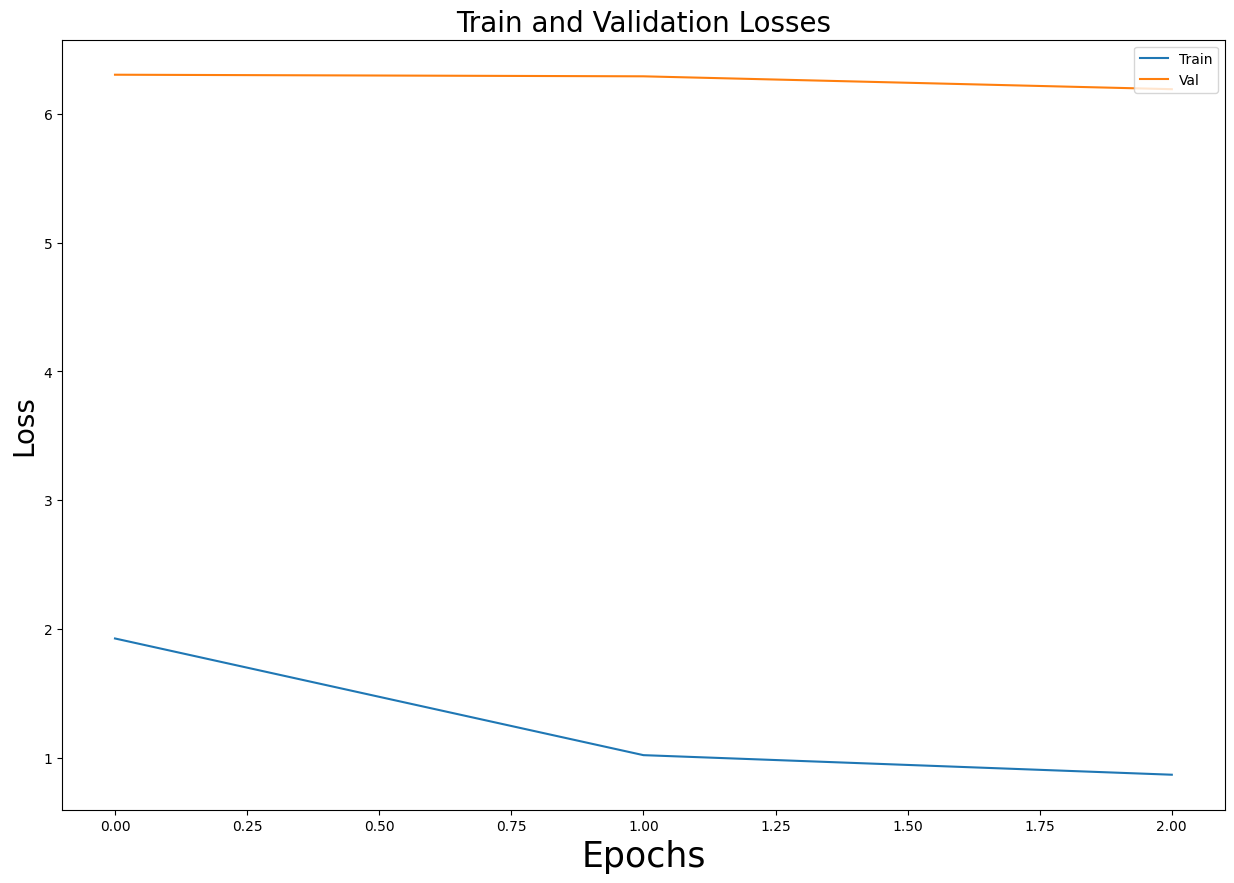

In [ ]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1,figsize=(15,10))

ax.set_title("Train and Validation Losses",size=20)
ax.set_ylabel('Loss', fontsize = 20)
ax.set_xlabel('Epochs', fontsize = 25)
_=ax.plot(train_losses)
_=ax.plot(val_losses)
_=ax.legend(('Train','Val'),loc='upper right')

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import torch

# Load the tokenizer and model
save_dir = "/content/drive/MyDrive/MODEL/Final_Model 2.0"  # Replace with the path where you saved your model
tokenizer = AutoTokenizer.from_pretrained(save_dir)
model = AutoModelForQuestionAnswering.from_pretrained(save_dir)

# Example question and context
Ques = input("Enter Question:")
question = Ques
context = "Bangladesh, officially known as the People's Republic of Bangladesh, is a country in South Asia. It is the eighth-most populous country in the world, with a population exceeding 160 million people. Dhaka, the capital and largest city of Bangladesh, is one of the most densely populated cities"

# Tokenize the input (question + context)
input_ids = tokenizer.encode(question, context, return_tensors='pt')

# Perform inference
with torch.no_grad():
    outputs = model(input_ids)

# Get the start and end logits from the output
start_logits = outputs.start_logits
end_logits = outputs.end_logits

# Get the answer by finding the tokens with the highest logits
start_index = torch.argmax(start_logits)
end_index = torch.argmax(end_logits)

# Decode the answer tokens
answer_tokens = input_ids[0, start_index:end_index+1]
answer = tokenizer.decode(answer_tokens)

#print("Question:", question)
print("Answer:", answer)





Enter Question:What is the capital of bangladesh?
Answer: dhaka,
